In [ ]:
### Idea was initially developed from the Reinforce algorithm, and since then there has been several
### variants of the policy gradient method

### The initial one developed from Gt or return from a particular action on a particular state, that served
### as the estimate of how good a particular action is for the state. More the return, better is the state.

### This is from where the idea of actor critic evolved. The method contains two parameterized networks, an actor and a critic

In [ ]:
### The actor is the policy parameterized neural network that provide the policy  
### The critic is the a parameterized value function that evaluates/estimates the value for the 
### action on the state.

### So, as Actor is a policy based function and Critic is a value based function. Actor-Critic methods
### lie in the intersection of policy based methods like Reinforce and VPG and value based methods like Q-learning and TD.

### Basically, the actor tells what should be the action on a particular state, and the critic tells
### how good is the action on that particular state.

### Several versions of the actor-critic methods have been developed based on the value function

In [ ]:
import matplotlib.pyplot as plt
import cv2

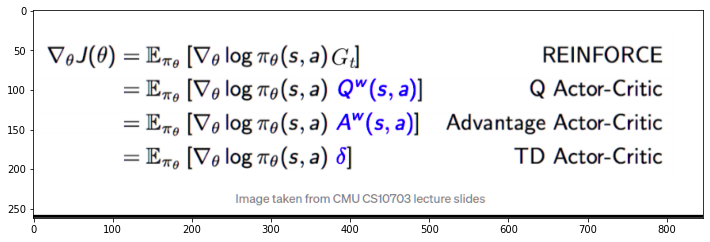

In [ ]:
vars=cv2.imread("Actor_critic.png")
plt.figure(figsize=(12,12))
plt.imshow(vars)
plt.show()

### Q Actor-Critic

In [ ]:
### In this case, Q(s,a) or the Q value is used as the Critic estimate.  

### the Actor update is given as:

### W1 = W1 + alpha1 * dJ(W1)/dw

### dJ(W1)/dw = d/dw [log(P(a|s)).Q(s,a)]

### The critic tries to minimize the MSE between 

### the boot strap value for the current state:  rt + gamma*Q(s',a') and

### the Q value prediction value for the state and action: Q(s,a)

### Algorithm as:

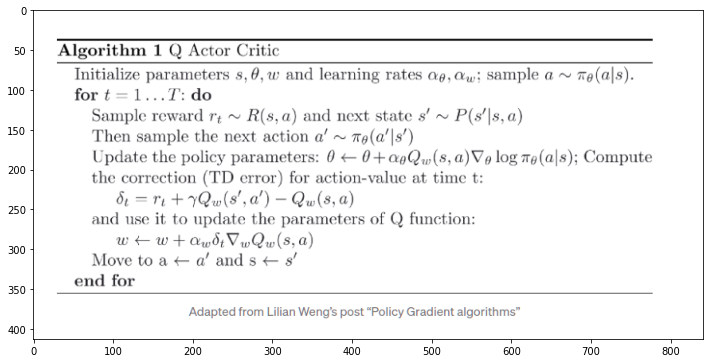

In [ ]:
image=cv2.imread("Q_actor_critc.png")
plt.figure(figsize=(12,12))
plt.imshow(image)
plt.show()

In [ ]:
### The baseline idea was brought into aspect, to replace Q(s,a: w) with Advantage A(s,a: w)
### as the estimating function.

### Now, A(st,at) = Q(st,at) - V(st)

### Using the V function as the baseline function, we subtract the Q value term with the V value. 
### Intuitively, this means how much better it is to take a specific action compared to the average, 
### general action at the given state.

### Now, to implement this, we will need three different networks, a policy based network, for the actor
### and for the critic we will need two different networks, one for the Q-value(Q(s,a) and another for the 
### V value V(s).

### Using 3 different network will be hugely time consuming and inefficient

In [ ]:
### To deal with this we use a bootstrapping relationship between Q(s,a) and V(s)

### Q(s,a) = E [r_(t+1) + gamma*V(s_(t+1))]

### As Q(s,a) is the expected sum of rewards for the action on the current state. We take it as the sum of
### Value Function, which is also an estimate of expected return for a state, of the next state,
### we reach by following the selected action on the current state and the reward of the next state reached on 
### taking the action on the current state.

### So, advantage can be rewritten as: 

### A(s_t,a_t) = r_(t+1)+ gamma*V(s_(t+1)) - V_(s_t)


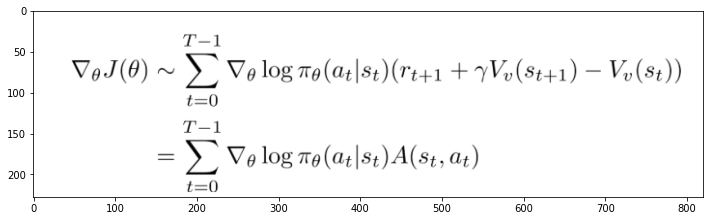

In [ ]:
vars=cv2.imread("A2C.png")
plt.figure(figsize=(12,12))
plt.imshow(vars)
plt.show()

In [ ]:
### The above equation shows the updated eqn for A2C. This is called Advantage Actor Critic

In [ ]:
### R_(t+1) + gamma * V(S_(t+1)) is known as the TD target

### R_(t+1) + gamma * V(S_(t+1)) - V(S(t)) ### It is called TD error.

### For Critic training, we minimize the MSE between R_(t+1) + gamma * V(S_(t+1)) and V(S_t)


In [ ]:
### A2C can be of 2 types: 

### 1. Online
### 2. Episodic

In [ ]:
### In episodic case, the agent, plays and logs the episodic details, which are used at once for the
### update. So, only after the full episode policy is updated

### In online case, for every tuple (s,a,r,s_) generated, the policy and the value function is updated.

### Cartpole problem

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

In [ ]:
import gym

In [ ]:
env=gym.make('CartPole-v0')
env._max_episode_steps=200

In [ ]:
class A2C:

  def __init__(self,env):

    self.env=env
    self.state_dimension=env.observation_space.shape   ### Input state dimension
    self.no_of_action=env.action_space.n              ### No of actions
    self.Actor=None      ### the learner
    self.Critic=None 
    self.opt=tf.keras.optimizers.RMSprop(lr=0.0007)
    self.goal=200
    self.steps_in_epi=250
    self.m=20

  def get_actor(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the probability distribution of the actions.

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer=tf.keras.layers.Dense(self.no_of_action, activation="softmax")(layer_3)

    ### Predicts the peobability of all the actions on the state s, so the number of nodes in
    ### the final layer of model is equal to the number of actions 
    ### and we generate a probabilistic distribution so softmax is used as the activation function.
    
    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])
    
    return model
  
  def get_critic(self):

    input_layer=tf.keras.layers.Input(self.state_dimension)  ### Takes the state for which we want to 
    ### predict the estimate value function V(s)

    layer_1=tf.keras.layers.Dense(128,activation="relu")(input_layer)
    layer_2=tf.keras.layers.Dense(128,activation="relu")(layer_1)
    layer_3=tf.keras.layers.Dense(128,activation="relu")(layer_2)
    
    output_layer=tf.keras.layers.Dense(1)(layer_3)  ### Predicts the Value function for that state.

    model=tf.keras.Model(inputs=[input_layer],outputs=[output_layer])
    
    
    return model

  def loss(self,S,A,Nd,Ns,R,gamma=0.99):

    ### Adv(St) = R_(t+1) + gamma * V(S_(t+1)) - V(S(t))
    ### V(St) is predicted by the Critic model.

    ### Before we use Adv in the model, we need to normalize the advantage values in order to 
    ### reduce the variance in the advantage values further more.
    ### This makes the optimization smoother and increases sample efficiency.

    #Adv=(Adv-Adv.mean())/Adv.std() ### standard scaling ### Normalization

    ### Updating the critic model weights.
    ### Passed the states, and the corresponding TD_targets.
    ### minimizes |R_(t+1) + gamma * V(S_(t+1)) - V(S(t))|^2 #### TD_target of the state 
    ### and the Value function prediction of the state

    m=S.shape[0] 
    log_pi_A_given_S=self.log_prob(S,A) 
    TD_target= R + gamma * Nd * self.Critic(Ns)
    Adv= TD_target - self.Critic(S)
    Adv=(Adv-tf.reduce_mean(Adv))/tf.math.reduce_std(Adv)
    actor_loss= -1*tf.reduce_sum(tf.multiply(log_pi_A_given_S,Adv))/m
    critic_loss= tf.reduce_mean(tf.math.squared_difference(self.Critic(S),TD_target))*0.5

    total_loss=actor_loss+0.25*critic_loss-0.01*self.entropy(S)

    return total_loss


  def action(self,s):

    s=s.reshape(1,-1)

    out=self.Actor(s)
    action_prob=tfp.distributions.Categorical(probs=out)
    action= action_prob.sample()
    ### sampling an action from the obtained probability distributions for all the action
    return action.numpy()[0]  ### Action returned as 1D tensor-> converting to scalar

  def log_prob(self,s,a):

    out=self.Actor(s)
    ### again to be used in batch
    action_prob=tfp.distributions.Categorical(probs=out)
    ### takes in the states and the actions and returns the corresponding log probability 
    ### of the occurence of the taken action a on the state s
    ### log(P[a|s : w]) is obtained.
    
    return action_prob.log_prob(a)

  def entropy(self,s):
    out=self.Actor(s)
    action_prob=tfp.distributions.Categorical(probs=out)
    return tf.reduce_mean(action_prob.entropy())
    ### Entropy is used in case of A2C in order to increase exploration.
    ## It is a 3rd component in the loss function.
    

  def get_episodes(self):
    ### To sample raw walks in the environment
    states=[]
    actions=[]
    rewards=[]
    next_states=[]
    not_done=[]
    

    done=False
    curr_state=self.env.reset()
    while not done:
      
      action=self.action(curr_state)
      next_state,reward,done,_=self.env.step(action)
      ### Obtaining next step.

      states.append(curr_state)
      actions.append(action)
      rewards.append(reward)
      next_states.append(next_state)
      not_done.append(not done)
      
      ### logging the essential required values for loss estimation

      curr_state=next_state ### Updating.

    return states,actions,rewards,next_states,not_done  ### All logs returned
  
  def get_experience(self,m):
    ### Get experience on the full batch :multiple sample
    states=[]
    actions=[]
    rewards=[]
    next_states=[]
    not_dones=[]

    V=0
    for i in range(m):
      S,A,R,Ns,Nd=self.get_episodes()
      
      ### For each episode in number of samples, collecting experience
      states.extend(S)
      actions.extend(A)
      rewards.extend(R)
      next_states.extend(Ns)
      not_dones.extend(Nd)

      R=sum(R)
      V+=R
      #### logging the stats of the ith sampling 
      ### "extend" not "append", as we want to create only one total set of episodes
    
    return np.array(states),np.array(actions),np.array(rewards),np.array(next_states),np.array(not_dones),V/m

  def train(self,gamma=0.99):
    curr_v=0
    target_v=self.goal
    self.Actor=self.get_actor()
    self.Critic=self.get_critic()
    total_v=0
    i=1
    while curr_v<target_v:

      S,A,R,Ns,Nd,curr_v=self.get_experience(self.m)
  
      total_v+=curr_v
      if i%50==0:
        total_v/=50
        print(f"Average on {i}: V: {total_v}")
        total_v=0       

      with tf.GradientTape() as t:
        total_loss=self.loss(S,A,Nd,Ns,R)
      
      grads=t.gradient(total_loss,self.Actor.trainable_variables+self.Critic.trainable_variables)
      self.opt.apply_gradients(zip(grads,self.Actor.trainable_variables+self.Critic.trainable_variables))

      i+=1


In [ ]:
agent=A2C(env)

In [ ]:
agent.train()